## Descriptors-based regression

## 1. Using SIFT descriptors

<p style="font-size: 16px;">
De la documentation relative à l'usage de la méthode SIFT est accessible sur les liens suivants : <br><br>
<a href="https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html">Scikit-Image</a> <br><br>
<a href="https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html">OpenCV</a><br>
</p>

In [1]:
import sys
import os
import random

sys.path.append(os.getcwd() + '/..')
sys.path.append(os.getcwd() + '/../..')

In [2]:
from get_data import load_data, load_label, fetch_particular_series, plot_series, load_particular_label

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pyproj
from pyproj import Proj
from skimage import data, transform
from skimage.feature import match_descriptors, plot_matches, SIFT

In [4]:
# load 2 images to ensure everything works fine
img1 = fetch_particular_series("009988", 1, data_directory="../../data/images/", grayscale=True)
img2 = fetch_particular_series("009988", 2, data_directory="../../data/images/", grayscale=True)

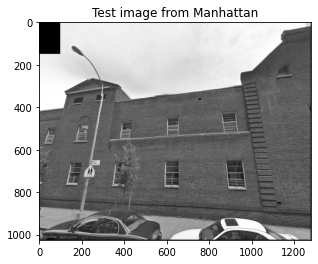

In [5]:
plt.title("Test image from Manhattan")
plt.imshow(img1.astype(np.uint8), cmap="gray")

Notice the pad in the top-left corner was cropped to prevent false matches with SIFT descriptors.

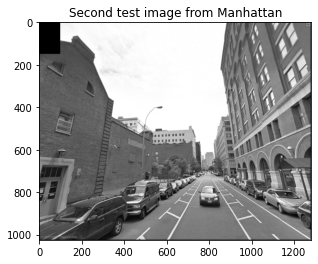

In [6]:
plt.title("Second test image from Manhattan")
plt.imshow(img2.astype(np.uint8), cmap="gray")

In [16]:
# when using scikit-image
descriptor_extractor_sk = SIFT() 

In [17]:
# from OpenCV - we can limit the number of descriptors, and this method is faster but empirically produces worst results
descriptor_extractor_cv = cv2.xfeatures2d.SIFT_create(nfeatures=1000)

In [18]:
# scikit-image's way to getting keypoints and descriptors - not used thereafter (just for reference)
descriptor_extractor_sk.detect_and_extract(img1)
keypoints_img1_sk = descriptor_extractor_sk.keypoints
descriptors_img1_sk = descriptor_extractor_sk.descriptors

In [19]:
keypoints_img1_cv, descriptors_img1_cv = descriptor_extractor_cv.detectAndCompute(img1, None)

Noter la différence de temps d'exécution ! À l'échelle, même si la méthode de Scikit-Image est meilleure, seule la méthode d'OpenCV est utilisable.

In [20]:
print(f"[SK] Nombre de point-clés trouvés : {len(keypoints_img1_sk)}\n Nombre de descripteurs trouvés : {len(descriptors_img1_sk)}")

[SK] Nombre de point-clés trouvés : 7575
 Nombre de descripteurs trouvés : 7575


In [21]:
print(f"[CV] Nombre de point-clés trouvés : {len(keypoints_img1_cv)}\n Nombre de descripteurs trouvés : {len(descriptors_img1_cv)}")

[CV] Nombre de point-clés trouvés : 1000
 Nombre de descripteurs trouvés : 1000


Remarque : on constate que la limitation du nombre de descripteurs a fonctionné.

In [22]:
keypoints_img2_cv, descriptors_img2_cv = descriptor_extractor_cv.detectAndCompute(img2, None)

In [24]:
# we will use OpenCV's BFMatcher (stand for Brute-Force Matcher) to compute matches among descriptors
bf = cv2.BFMatcher()
# matches will be computed using k-Nearest Neighbors method in the descriptors' space
matches_cv = bf.knnMatch(descriptors_img1_cv, descriptors_img2_cv, k=2)

In [25]:
# just for reference - scikit-image's way of computing matches is the following:
matches = match_descriptors(descriptors_img1_cv,
                            descriptors_img2_cv,
                            max_ratio=0.6,
                            cross_check=True)

In [28]:
# filter good matches - OpenCV does not filter good matches natively
good = []
for m, n in matches_cv:
    if m.distance < 0.5*n.distance:
        # the above 0.75 will be a variable below
        good.append([m])

In [29]:
res = cv2.drawMatchesKnn(img1, keypoints_img1_cv, img2, keypoints_img2_cv, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

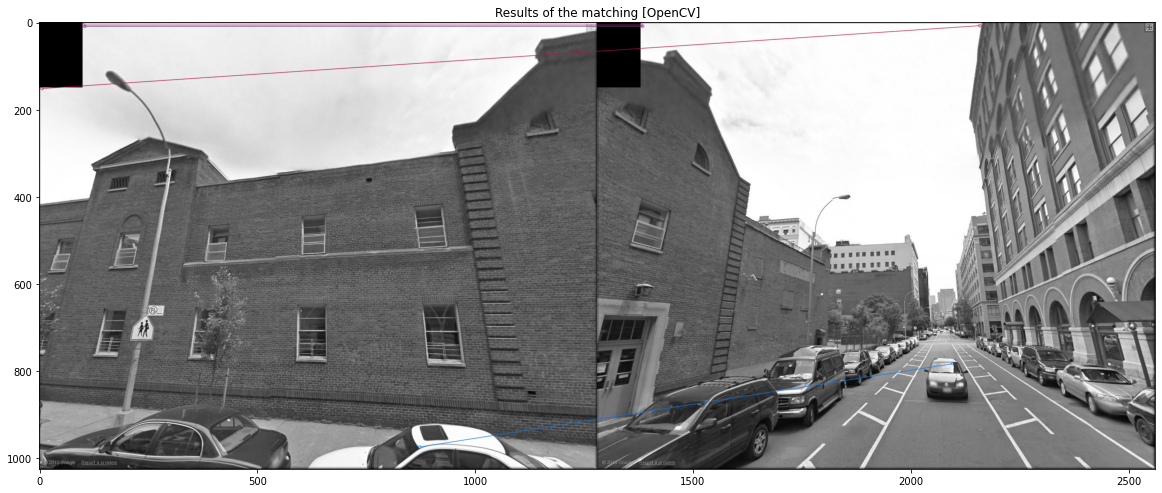

In [30]:
plt.figure(figsize=(20, 10))
plt.title("Results of the matching [OpenCV]")
plt.imshow(res)
plt.show()

On a limité les matchs dûs au pad en haut à gauche mais il en reste quelques uns. Beaucoup de faux positifs avec un seuil à 0.75, beaucoup moins avec 0.5.

In [25]:
# the following ligns are only relevant when using scikit-image's SIFT implementation (comparison of un-restricted and restricted # of matches)
# print("Nombre de match version full :", len(matches))
# print("Nombre de match version short :", len(matches_short))
# print("Ratio nombre de descripteurs total/nombre de match pour la version full : {}%".format(round(100*len(matches)/len(descriptors_img1), 2)))
# print("Ratio nombre de descripteurs total/nombre de match pour la version short : {}%".format(round(100*len(matches_short)/len(descriptors_img1_short), 2)))

Nombre de match version full : 67
Nombre de match version short : 19
Ratio nombre de descripteurs total/nombre de match pour la version full : 0.88%
Ratio nombre de descripteurs total/nombre de match pour la version short : 19.0%


In [31]:
print("Nombre de match total version OpenCV :", len(matches_cv))
print("Nombre de match filtrés version OpenCV :", len(good))
print("Ratio nombre de descripteurs total/nombre de match : {}%".format(round(100*len(good)/len(descriptors_img1_cv), 2)))

Nombre de match total version OpenCV : 1000
Nombre de match filtrés version OpenCV : 4
Ratio nombre de descripteurs total/nombre de match : 0.4%


In [32]:
nb_matches = len(matches)

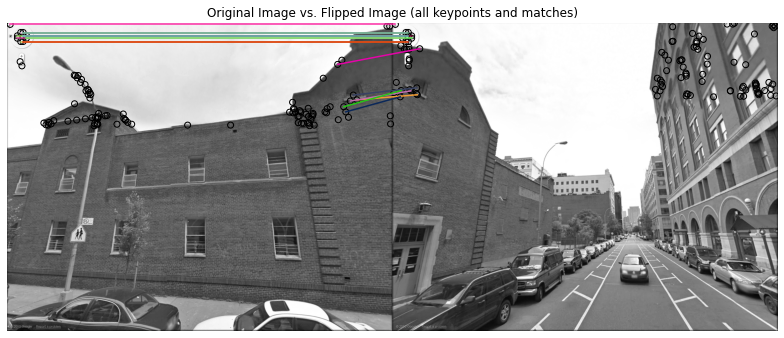

In [38]:
# when using scikit-image's SIFT - for plotting results
# fig, ax = plt.subplots(1, 1, figsize=(11, 8))
# plt.gray()
# plot_matches(ax, img1, img2, keypoints_img1, keypoints_img2, matches)
# ax.axis('off')
# ax.set_title("Original Image vs. Flipped Image (all keypoints and matches)")
# plt.tight_layout()
# plt.show()

Avec SK - pour référence : en gardant le pad en haut à gauche, les résultats sont biaisés car chaque paire d'images possède des matchs !

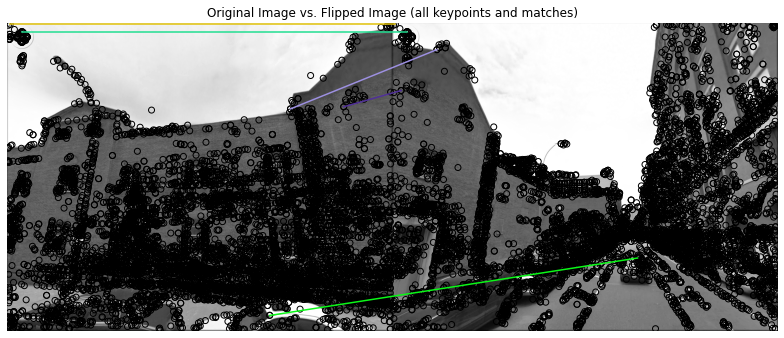

In [ ]:
# when using scikit-image's SIFT - for plotting results
# fig, ax = plt.subplots(1, 1, figsize=(11, 8))
# plt.gray()
# plot_matches(ax, img1, img2, keypoints_img1, keypoints_img2, matches[::15])
# ax.axis('off')
# ax.set_title("Original Image vs. Flipped Image (short version)")
# plt.tight_layout()
# plt.show()

Conclusion: need to crop images so as to prevent matches between the pad arrows! 
May be possible to detect close images based on SIFT descriptors using a retrieval approach. 

## 2. Towards descriptors-retrieval based regression

In [18]:
# start by creating a base of descriptors-label
def create_database_opencv(ids_in_database: list = ["009900", "009902", "009992", "009994", "010207"], nb_descriptors: int = 1000):
    """
    Create a mapping between descriptors and labels (Cartesian coordinates).
    """
    descriptor_extractor = cv2.xfeatures2d.SIFT_create(nfeatures=nb_descriptors)
    database_ids = ids_in_database
    database = {}
    count = 1
    for image_id in database_ids:
        print(f"Creating database: {count}/{len(database_ids)}")
        img = fetch_particular_series(image_id, 1, data_directory="../../data/images/", grayscale=True)
        keypoints, descriptors = descriptor_extractor.detectAndCompute(img, None)
        (x, y) = load_particular_label(image_id, path = "../../data/labels.mat")
        database[(x, y)] = descriptors
        count += 1
    return database

In [51]:
# scikit-image version
# def create_database(ids_in_database: list = ["009900", "009902", "009992", "009994", "010207"], nb_descriptors: int = 100):
#     """
#     Create a mapping between descriptors and labels (Cartesian coordinates).
#     """
#     descriptor_extractor = SIFT()
#     database_ids = ids_in_database
#     database = {}
#     count = 1
#     for image_id in database_ids:
#         print(f"Creating database: {count}/{len(database_ids)}")
#         img = fetch_particular_series(image_id, 1, data_directory="../../data/images/", grayscale=True)
#         descriptor_extractor.detect_and_extract(img)
#         descriptors = descriptor_extractor.descriptors[:nb_descriptors]
#         (x, y, _) = load_particular_label(image_id, path = "../../data/labels.mat")
#         key = "(" + str(x) + "," + str(y) + ")"
#         database[key] = descriptors
#         count += 1
#     return database

In [5]:
def infer_image_cartesian_coordinates(inference_image, database: dict, nb_descriptors: int = 100, thresh: float = 0.75):
    """ 
    Run inference with descriptors-based retrieval regression.
    """
    initial_location = (0.0, 0.0)
    average_x_coord, average_y_coord = [], []
    descriptor_extractor = cv2.xfeatures2d.SIFT_create(nfeatures=nb_descriptors)
    inference_keypoints, inference_descriptors = descriptor_extractor.detectAndCompute(inference_image, None)
    bf = cv2.BFMatcher()

    for location, descriptors in database.items():    
        matches = bf.knnMatch(descriptors, inference_descriptors, k=2)
        # filter good matches
        good_matches = []
        for m, n in matches:
            if m.distance < thresh*n.distance:
                good_matches.append([m])
        # only good matches/filtered matches matter!
        nb_matches = len(good_matches)
        for i in range(nb_matches):
            # pondération par le nombre de matchs
            average_x_coord.append(location[0])
            average_y_coord.append(location[1])
    x_infer = np.mean(average_x_coord)
    y_infer = np.mean(average_y_coord)
    if (x_infer is None) or (y_infer is None):
        return initial_location
    else:
        return (x_infer, y_infer)

In [59]:
# scikit-image version
# def infer_image_cartesian_coordinates(inference_image, database: dict):
#     """ 
#     Run inference with descriptors-based retrieval regression.
#     """
#     initial_location = (0.0, 0.0)
#     average_x_coord, average_y_coord = [], []
#     descriptor_extractor = SIFT()
#     descriptor_extractor.detect_and_extract(inference_image)
#     inference_descriptors = descriptor_extractor.descriptors
#     for location, descriptors in database.items():
#         matches = match_descriptors(descriptors,
#                                 inference_descriptors,
#                                 max_ratio=0.6,
#                                 cross_check=True)
#         nb_matches = len(matches)
#         for i in range(nb_matches):
#             # pondération par le nombre de matchs
#             average_x_coord.append(location[0])
#             average_y_coord.append(location[1])

#     x_infer = np.mean(average_x_coord)
#     y_infer = np.mean(average_y_coord)
#     if (x_infer is None) or (y_infer is None):
#         return initial_location
#     else:
#         return (x_infer, y_infer)

In [41]:
database = create_database_opencv()

Creating database: 1/5
Creating database: 2/5
Creating database: 3/5
Creating database: 4/5
Creating database: 5/5


In [42]:
database.keys()

dict_keys([(40.743143, -74.008754), (40.743285, -74.008726), (40.733099, -74.007463), (40.733307, -74.007414), (40.717808, -74.005696)])

In [43]:
# try inference
inference_id = "009993"
image_inference = fetch_particular_series(inference_id, 1, data_directory="../../data/images/", grayscale=True)
(x_true, y_true, _) = load_particular_label(inference_id, path = "../../data/labels.mat")
(x_infer, y_infer) = infer_image_cartesian_coordinates(image_inference, database)

[40.733307, 40.733307, 40.717808]


In [44]:
# évaluation de la performance
print(f"x_true: {x_true}, y_true: {y_true}")
print(f"x_infer: {x_infer}, y_infer: {y_infer}")

x_true: 40.73319, y_true: -74.007441
x_infer: 40.72814066666667, y_infer: -74.00684133333333


In [6]:
def compute_distance(coord_infer: tuple, coord_true: tuple):
    """
    Compute the Cartesian distance between the infered and true coordinates.
    """
    inProj = Proj(init='epsg:4326') # (lat, long)
    outProj = Proj(init='epsg:2154') # Lambert 93
    x1, y1 = 882408.3,6543019.6
    x_true_l93, y_true_l93 = pyproj.transform(inProj, outProj, x_true, y_true)
    x_infer_l93, y_infer_l93 = pyproj.transform(inProj, outProj, x_infer, y_infer)
    dist = np.sqrt(
        (x_true_l93 - x_infer_l93)**2 + (y_true_l93 - y_infer_l93)**2
    )
    # print(f"Cartesian distance: {round(dist, 1)} meters.")
    return dist

In [46]:
dist = compute_distance((x_infer, y_infer), (x_true, y_true))

C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_13108\3024225497.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-

Cartesian distance: 3384.2 meters.


C:\Users\cleme\AppData\Local\Temp\ipykernel_13108\3024225497.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_infer_l93, y_infer_l93 = pyproj.transform(inProj, outProj, x_infer, y_infer)


Conclusion : construire la base de données est très coûteux en temps et la comparaison des descripteurs pour l'inférence est très coûteuse en temps également mais la solution semble au final bien fonctionner.

## 3. Evaluating the model on the problem's data

In [7]:
# on commence par couper le jeu de données en train, test (pas de validation car pas de sélection d'hyperparamètres)
all_filenames = os.listdir("../../data/images")
all_ids = list(set([item.split("_")[0] for item in all_filenames]))
all_ids = all_ids
N = len(all_ids)
# shuffle IDs
random.shuffle(all_ids)
# 20% des données pour le test, 80% pour constituer la base de données
train_test_ratio = 0.9
X_train_ids = all_ids[:int(train_test_ratio*N)]
X_test_ids = all_ids[int(train_test_ratio*N):]
print(len(X_train_ids))
print(len(X_test_ids)) 

399
45


In [20]:
database = create_database_opencv(X_train_ids, nb_descriptors=1000)

Creating database: 1/399
Creating database: 2/399
Creating database: 3/399
Creating database: 4/399
Creating database: 5/399
Creating database: 6/399
Creating database: 7/399
Creating database: 8/399
Creating database: 9/399
Creating database: 10/399
Creating database: 11/399
Creating database: 12/399
Creating database: 13/399
Creating database: 14/399
Creating database: 15/399
Creating database: 16/399
Creating database: 17/399
Creating database: 18/399
Creating database: 19/399
Creating database: 20/399
Creating database: 21/399
Creating database: 22/399
Creating database: 23/399
Creating database: 24/399
Creating database: 25/399
Creating database: 26/399
Creating database: 27/399
Creating database: 28/399
Creating database: 29/399
Creating database: 30/399
Creating database: 31/399
Creating database: 32/399
Creating database: 33/399
Creating database: 34/399
Creating database: 35/399
Creating database: 36/399
Creating database: 37/399
Creating database: 38/399
Creating database: 39

In [41]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
# run inference and compute the average losse
losses = []
count = 1
for inference_id in X_test_ids:
    print(f"Count: {count}/{len(X_test_ids)}")
    image_inference = fetch_particular_series(inference_id, 1, data_directory="../../data/images/", grayscale=True)
    (x_true, y_true) = load_particular_label(inference_id, path = "../../data/labels.mat")
    (x_infer, y_infer) = infer_image_cartesian_coordinates(image_inference, database, thresh=0.5)
    print(x_true, y_true, x_infer, y_infer)
    dist = compute_distance((x_infer, y_infer), (x_true, y_true))
    print(dist)
    if dist > 0:
        losses.append(dist)
        count += 1

Count: 1/45
40.736242 -74.006669 40.73049692727271 -74.00661895454546
3537.9219180695386
Count: 2/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.713411 -74.009131 40.72870486746987 -74.00672063855421
10844.253336679829
Count: 3/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.737182 -74.006494 40.72724745901639 -74.00678169398905
6148.467752801827
Count: 4/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.741637 -74.006994 40.73050970165745 -74.00738348618783
6904.144598137758
Count: 5/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.745531 -74.008268 40.73344996456694 -74.00711178740157
7871.833332536142
Count: 6/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.746434 -74.008133 40.727453252032525 -74.0065351300813
12215.915308358635
Count: 7/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.742384 -74.007995 40.731199650862074 -74.0070093362069
7227.646247154603
Count: 8/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.712972 -74.009471 40.72540645856354 -74.0064307320442
10231.237738503072
Count: 9/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.723688 -74.004766 40.732218710344824 -74.00686874482759
7043.268952183873
Count: 10/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.743143 -74.008754 40.73503813157895 -74.0083222368421
5081.39696248228
Count: 11/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.721125 -74.005286 40.72907624590164 -74.00634740983605
5437.440624863371
Count: 12/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.729405 -74.002327 40.730130290909095 -74.0062194
8700.23957846199
Count: 13/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.715821 -74.007232 40.72613544470046 -74.0062043686636
6750.5960787112745
Count: 14/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.738329 -74.006467 40.727808051282054 -74.00680818803417
6520.415735909902
Count: 15/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.741038 -74.007412 40.730069937500005 -74.007382140625
6751.52857727784
Count: 16/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.732271 -74.007677 40.728978711185306 -74.00632150250418
3642.443456497857
Count: 17/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.735432 -74.006872 40.73354134117647 -74.00666147647058
1255.079510771236
Count: 18/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.751418 -74.008173 40.750015 -74.008456
1070.1753361626504
Count: 19/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.736529 -74.006598 40.73167715094339 -74.00677410849056
3012.1498548448976
Count: 20/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.744104 -74.008578 40.7405166849315 -74.0080372328767
2516.8548239149663
Count: 21/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.727731 -74.0031 40.72996067889908 -74.00664144954128
8024.093935962016
Count: 22/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.733987 -74.007241 40.73318333333333 -74.00727555555555
500.6615147065767
Count: 23/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.731462 -74.007897 40.73097293548387 -74.00685921370967
2336.830767507727
Count: 24/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.743285 -74.008726 40.734050705882346 -74.00736360784313
6447.183204846049
Count: 25/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.709245 -74.011977 40.725812469999994 -74.00796746999998
13572.936639096959
Count: 26/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.727245 -74.003283 40.730865610389614 -74.00762353246756
9943.266437975559
Count: 27/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.751 -74.00833 40.732742820388346 -74.00726231553398
11488.224608449507
Count: 28/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.729143 -74.002451 40.727699297989034 -74.00650651736744
9096.595761902816
Count: 29/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.726689 -74.003516 40.726455124999994 -74.00382975000001
714.9590671211178
Count: 30/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.729786 -74.002143 40.727531875 -74.00735704545455
11721.992998365047
Count: 31/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.734817 -74.007031 40.729012499999996 -74.00718710000001
3589.773533226982
Count: 32/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.74114 -74.007337 40.730503822335024 -74.00693987817259
6606.615725948107
Count: 33/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.716676 -74.006567 40.72916493721972 -74.00639665919283
7696.427093606497
Count: 34/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.732019 -74.007744 40.7300375 -74.0056005
4938.996357713594
Count: 35/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.714472 -74.008295 40.71976550220264 -74.00789803524229
3376.863000906441
Count: 36/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.717213 -74.00615 40.725093782608695 -74.0066992173913
5003.26395854005
Count: 37/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.749702 -74.00838 nan nan
nan
Count: 37/45
40.72286 -74.005102 40.72544375252525 -74.00570707070706
2086.526671992371
Count: 38/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.723523 -74.004837 40.72783877152318 -74.00673185761588
4995.274799416453
Count: 39/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.719344 -74.005178 40.726333504950496 -74.00615382178218
4822.11994294437
Count: 40/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.736335 -74.006645 40.73013710800508 -74.00667929987293
3815.6440431783
Count: 41/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.739144 -74.006455 40.7326068655462 -74.00661939495798
4040.367753966158
Count: 42/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.737855 -74.006478 40.73206393333333 -74.00687030666666
3670.5235638124923
Count: 43/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.739667 -74.006314 40.72779150110865 -74.00747075609756
7752.505415304754
Count: 44/45


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

40.720922 -74.005288 40.728041660377365 -74.00651445283019
5167.249615036145


C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Roaming\Python\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\cleme\AppData\Local\Temp\ipykernel_9692\2091205474.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-p

In [22]:
average_loss = np.mean(losses)
print("Average loss (in meters) for the descriptors-based retrieval regression method: {} meters.".format(round(average_loss, 2)))

Average loss (in meters) for the descriptors-based retrieval regression method: 6003.91 meters.


In [23]:
DUMMY_LOSS = 8334 # average error in meters of the dummy regression (see baseline-model)
print("The descriptors-based retrieval regression method outperforms the dummy regression by {}%".format(
    round(100*(DUMMY_LOSS - average_loss)/DUMMY_LOSS, 2)
))

The descriptors-based retrieval regression method outperforms the dummy regression by 27.96%
